<a href="https://colab.research.google.com/github/akshaypat444/tensorflow_practice/blob/main/08_natural_language_processing_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Mar 18 14:55:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0              23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Get helper functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-03-18 14:56:03--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-03-18 14:56:04 (10.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys, unzip_data

## Get the data

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

unzip_data('nlp_getting_started.zip')

--2024-03-18 14:56:12--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.188.207, 64.233.189.207, 108.177.97.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.188.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K   766KB/s    in 0.8s    

2024-03-18 14:56:13 (766 KB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [6]:
train_data= pd.read_csv('train.csv')
test_data= pd.read_csv('test.csv')

In [7]:
train_data.shape, test_data.shape

((7613, 5), (3263, 4))

In [ ]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## Pre-process data

In [8]:
train_data = train_data.drop('keyword', axis=1).drop('location', axis=1).drop('id', axis=1)
test_data = test_data.drop('location', axis=1).drop('id', axis=1).drop('keyword', axis=1)

In [ ]:
train_data.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
# Need to shuffle since target is 1 and then 0
train_df_shuffled = train_data.sample(frac=1, random_state=42)
train_df_shuffled.head()

,text,target
2644,So you have a new weapon that can cause un-ima...,1
2227,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,Aftershock back to school kick off was great. ...,0
6845,in response to trauma Children of Addicts deve...,0


In [ ]:
# Check if data is imbalanced
train_data.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [10]:
import random
random_index = random.randint(0, len(train_df_shuffled)-5)

for row in train_df_shuffled[random_index:random_index+5].itertuples():
  print(row.target)
  print(row.text)
  print('\n')

0
So when you're caught in a landslide
I'll be there for you
And in the rain 
give you sunshine
I'll be there for you


1
Two trains have collided in India. Please pray for victims their families and rescuers.


0
@questergirl ditto but its all we had. and the way i feel if i drank vodka over ice they would have to body bag me


0
#Turkish couple decided to feed 4000 #Syrian #refugees as part of their #wedding celebrations http://t.co/EHLq3ZSPTd http://t.co/DjX5eLbrv1


1
There's a sinkhole in Brooklyn ?!




## Split data into training and validation dataset

In [11]:
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                  train_df_shuffled["target"].to_numpy(),
                                                  test_size=0.1, random_state=42)
print(train_sentences.shape)
print(val_sentences.shape)
print(train_labels.shape)
print(val_labels.shape)

(6851,)
(762,)
(6851,)
(762,)


## Converting text to numbers
1. Tokenization - straight mapping to numbers
2. Embeddings - richer representations of the relationships between tokens

### 1. Tokenization (Text Vectorization)

In [12]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# These are default values
text_vectorizer = TextVectorization(max_tokens=None, # How many words in the vocabulary
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None, # Create groups of n-words
                                    output_mode="int",
                                    output_sequence_length=None, # Pads to the longest sequence
                                    pad_to_max_tokens=False)

In [ ]:
round(sum([len(i.split()) for i in train_sentences]) / len(train_sentences))

15

In [13]:
max_vocab_length = 10000 # max number of words to have in vocabulary
max_length = 15  # max length of sequence i.e. tweet

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)
# Fit the text vectorizer
train_vectorized = text_vectorizer.adapt(train_sentences)

In [14]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [15]:
# Convert random sentence from training dataset and convert it to vector of int
# using vectorizer
random_sentence = random.choice(train_sentences)
print(random_sentence)
print(text_vectorizer([random_sentence]))

Russian 'food crematoria' provoke outrage amid crisis famine memories http://t.co/GyH00mRKjm
tf.Tensor(
[[ 835  260 1147 1114  935  714  745  459  647    1    0    0    0    0
     0]], shape=(1, 15), dtype=int64)


In [16]:
# Get the unique words in vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print("Top 5 words: ", top_5_words)
print("Bottom 5 words: ", bottom_5_words)

Top 5 words:  ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 words:  ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


In [ ]:
# Vocabulary size
len(words_in_vocab)

10000

### 3. Embedding layer - Dense vector representation

1. `input_dim` = size of vocabulary (1000 here)
2. `output_dim` = output vector size (may be 100)
3. `input_length` = length of sentence or sequence

In [17]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # 10000
                             output_dim=128,
                             input_length=max_length  # 15
                             )
embedding

In [18]:
random_sentence = random.choice(train_sentences)
embedded_text = embedding(text_vectorizer(random_sentence))
print(random_sentence)
print(embedded_text)
print(embedded_text.shape)

@sabcnewsroom sabotage!I rule out structural failure
tf.Tensor(
[[ 0.00025614  0.01842964  0.02981945 ... -0.03143652 -0.00210872
   0.04457063]
 [-0.02901349 -0.02288945  0.03664966 ... -0.04719033  0.02465114
   0.00761129]
 [-0.01004931  0.03447447 -0.00860555 ...  0.01794908 -0.03269655
  -0.00019512]
 ...
 [-0.03466671 -0.01302116  0.02287321 ...  0.03467138  0.0497652
   0.01751378]
 [-0.03466671 -0.01302116  0.02287321 ...  0.03467138  0.0497652
   0.01751378]
 [-0.03466671 -0.01302116  0.02287321 ...  0.03467138  0.0497652
   0.01751378]], shape=(15, 128), dtype=float32)
(15, 128)


In [ ]:
# The embedding weights will get updated as we train the model

## Model 0 - Naive Bayes baseline

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate the baseline model
baseline_score = model_0.score(val_sentences, val_labels)
baseline_score

0.7926509186351706

In [ ]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics(true_labels, preds):
  return {"accuracy": accuracy_score(true_labels, preds) * 100,
          "precision": precision_score(true_labels, preds) * 100,
          "recall": recall_score(true_labels, preds) * 100,
          "f1": f1_score(true_labels, preds) * 100}

In [ ]:
baseline_results = calculate_metrics(val_labels, baseline_preds)

NameError: name 'baseline_preds' is not defined

## Model 1: Dense neural network

In [27]:
# Create a tensorboard callback
from helper_functions import create_tensorboard_callback, plot_loss_curves

SAVE_DIR = "model_logs"

In [ ]:
from tensorflow.keras import layers

inputs= layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 1280129 (4.

In [ ]:
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20240313-031600
Epoch 1/5
215/215 [==============================] - 8s 27ms/step - loss: 0.6099 - accuracy: 0.6868 - val_loss: 0.5316 - val_accuracy: 0.7651
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.4407 - accuracy: 0.8193 - val_loss: 0.4728 - val_accuracy: 0.7874
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.3467 - accuracy: 0.8624 - val_loss: 0.4567 - val_accuracy: 0.7913
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.2837 - accuracy: 0.8927 - val_loss: 0.4658 - val_accuracy: 0.7913
Epoch 5/5
215/215 [==============================] - 1s 4ms/step - loss: 0.2370 - accuracy: 0.9118 - val_loss: 0.4809 - val_accuracy: 0.7808


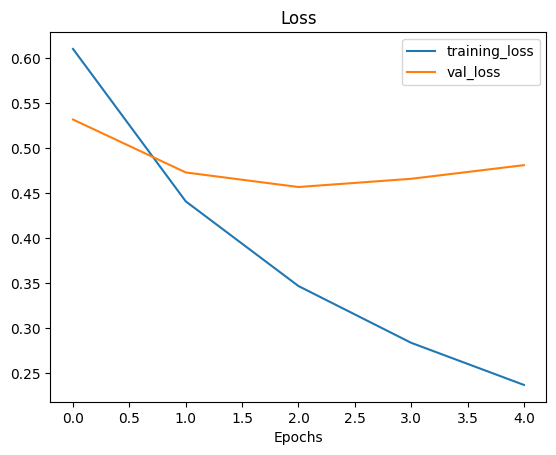

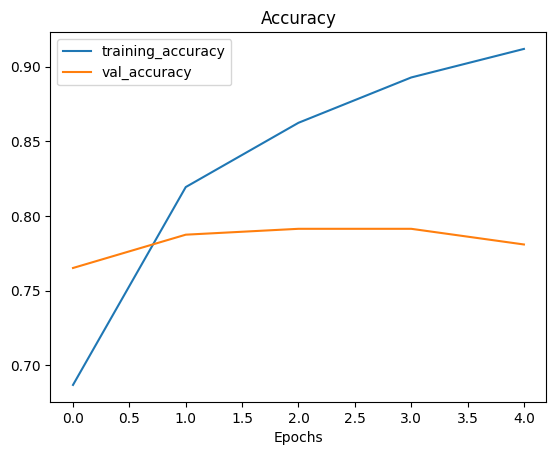

In [ ]:
plot_loss_curves(model_1_history)

In [ ]:
model_1_preds = model_1.predict(val_sentences)
model_1_preds = tf.squeeze(tf.round(model_1_preds)).numpy()
model_1_results = calculate_metrics(val_labels, model_1_preds)

24/24 [==============================] - 0s 2ms/step


In [ ]:
baseline_results, model_1_results

({'accuracy': 79.26509186351706,
  'precision': 88.6178861788618,
  'recall': 62.643678160919535,
  'f1': 73.4006734006734},
 {'accuracy': 78.08398950131233,
  'precision': 81.31487889273356,
  'recall': 67.52873563218391,
  'f1': 73.78335949764521})

## Visualize Model learned embeddings

In [20]:
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab)

10000

In [ ]:
# Model_1 summary
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 1280129 (4.

In [21]:
embed_weights = model_1.get_layer("embedding").get_weights()[0]

NameError: name 'model_1' is not defined

In [22]:
embed_weights.shape

NameError: name 'embed_weights' is not defined

In [23]:
import io

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

NameError: name 'embed_weights' is not defined

In [ ]:
## Dowload the files and upload it to https://projector.tensorflow.org/
## vector and metadata file for visualization

## Model 2 -> LSTM (RNN)

In [24]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
x = layers.LSTM(64, return_sequences=True)(x)
print(x.shape)
x = layers.LSTM(64)(x)
print(x.shape)
x= layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_2.summary()

(None, 15, 128)
(None, 15, 64)
(None, 64)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 15, 64)            49408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                   

In [28]:
model_2_history = model_2.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_2_lstm")])

Saving TensorBoard log files to: model_logs/model_2_lstm/20240318-145806
Epoch 1/5
215/215 [==============================] - 12s 36ms/step - loss: 0.5097 - accuracy: 0.7476 - val_loss: 0.4624 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3142 - accuracy: 0.8692 - val_loss: 0.4802 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.2212 - accuracy: 0.9169 - val_loss: 0.6050 - val_accuracy: 0.7756
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1490 - accuracy: 0.9469 - val_loss: 0.7475 - val_accuracy: 0.7664
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1090 - accuracy: 0.9597 - val_loss: 0.9801 - val_accuracy: 0.7638


In [29]:
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[0.03435083],
       [0.37884644],
       [0.9999008 ],
       [0.03952951],
       [0.00287814],
       [0.9999912 ],
       [0.47501117],
       [0.99999356],
       [0.99999404],
       [0.05297315]], dtype=float32)

In [30]:
model_2_results = calculate_metrics(val_labels, tf.squeeze(tf.round(model_2_pred_probs)))
model_2_results

{'accuracy': 76.37795275590551,
 'precision': 79.37062937062937,
 'recall': 65.22988505747126,
 'f1': 71.60883280757098}

## Model 3: GRU
1. Gated recurrent neural network

In [38]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64, return_sequences=True)(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_gru")

model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_3.summary()

Model: "model_3_gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru_5 (GRU)                 (None, 15, 64)            37248     
                                                                 
 global_average_pooling1d_1  (None, 64)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_5 (Dense)             (None, 1)                 

In [39]:
history_model_3 = model_3.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_2_lstm")])

Saving TensorBoard log files to: model_logs/model_2_lstm/20240318-153100
Epoch 1/5
215/215 [==============================] - 9s 33ms/step - loss: 0.2102 - accuracy: 0.9251 - val_loss: 0.6652 - val_accuracy: 0.7651
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0999 - accuracy: 0.9625 - val_loss: 0.7215 - val_accuracy: 0.7572
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0789 - accuracy: 0.9683 - val_loss: 0.8828 - val_accuracy: 0.7638
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0630 - accuracy: 0.9740 - val_loss: 1.2376 - val_accuracy: 0.7572
Epoch 5/5
215/215 [==============================] - 1s 7ms/step - loss: 0.0556 - accuracy: 0.9746 - val_loss: 1.4444 - val_accuracy: 0.7428


In [40]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[0.06821892],
       [0.91478056],
       [0.9999261 ],
       [0.11840113],
       [0.00156303],
       [0.9999933 ],
       [0.9992079 ],
       [0.999998  ],
       [0.99998844],
       [0.5012649 ]], dtype=float32)

In [41]:
model_3_results = calculate_metrics(val_labels, tf.squeeze(tf.round(model_3_pred_probs)))
model_3_results

{'accuracy': 74.2782152230971,
 'precision': 73.03030303030303,
 'recall': 69.25287356321839,
 'f1': 71.0914454277286}

## Model 4: Bidirectional LSTM

In [43]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_gru")

model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_model_4 = model_4.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_4_lstm")])

model_4_pred_probs = model_4.predict(val_sentences)
model_4_results = calculate_metrics(val_labels, tf.squeeze(tf.round(model_4_pred_probs)))

Saving TensorBoard log files to: model_logs/model_4_lstm/20240318-154146
Epoch 1/5
215/215 [==============================] - 15s 41ms/step - loss: 0.1050 - accuracy: 0.9635 - val_loss: 1.1212 - val_accuracy: 0.7585
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0504 - accuracy: 0.9781 - val_loss: 1.3170 - val_accuracy: 0.7559
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0475 - accuracy: 0.9791 - val_loss: 1.3797 - val_accuracy: 0.7493
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0417 - accuracy: 0.9801 - val_loss: 1.5060 - val_accuracy: 0.7520
Epoch 5/5
24/24 [==============================] - 1s 4ms/step


In [45]:
model_4_results

{'accuracy': 76.24671916010499,
 'precision': 75.85139318885449,
 'recall': 70.40229885057471,
 'f1': 73.02533532041728}